VGG16
=====

trained by facebook, from PyTorch model zoo.

http://www.robots.ox.ac.uk/~vgg/research/very_deep/

### Network info

trained in PyTorch

Test top-1/top5 error: **30.09, 10.61**
    
The accuracy is lower than original caffe model.

In [1]:
import re
import hickle as hkl
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchviz import make_dot

In [3]:
params = hkl.load('vgg16.hkl')

# convert numpy arrays to torch Variables
for k,v in sorted(params.items()):
    print(k, tuple(v.shape))
    params[k] = Variable(torch.from_numpy(v), requires_grad=True)
    
print('\nTotal parameters:', sum(v.numel() for v in params.values()))

classifier.0.bias (4096,)
classifier.0.weight (4096, 25088)
classifier.3.bias (4096,)
classifier.3.weight (4096, 4096)
classifier.6.bias (1000,)
classifier.6.weight (1000, 4096)
features.0.bias (64,)
features.0.weight (64, 3, 3, 3)
features.10.bias (256,)
features.10.weight (256, 128, 3, 3)
features.12.bias (256,)
features.12.weight (256, 256, 3, 3)
features.14.bias (256,)
features.14.weight (256, 256, 3, 3)
features.17.bias (512,)
features.17.weight (512, 256, 3, 3)
features.19.bias (512,)
features.19.weight (512, 512, 3, 3)
features.2.bias (64,)
features.2.weight (64, 64, 3, 3)
features.21.bias (512,)
features.21.weight (512, 512, 3, 3)
features.24.bias (512,)
features.24.weight (512, 512, 3, 3)
features.26.bias (512,)
features.26.weight (512, 512, 3, 3)
features.28.bias (512,)
features.28.weight (512, 512, 3, 3)
features.5.bias (128,)
features.5.weight (128, 64, 3, 3)
features.7.bias (128,)
features.7.weight (128, 128, 3, 3)

Total parameters: 138357544


## PyTorch model definition

In [10]:
def f(inputs, params):
    def conv2d(x, params, name, stride=1, padding=0):
        return F.conv2d(x,
                        params['%s.weight'%name],
                        params['%s.bias'%name], stride, padding)
    
    def linear(x, params, name):
        return F.linear(x, params['%s.weight' % name], params['%s.bias' % name])

    def block(x, ids):
        for i in ids:
            x = F.relu(conv2d(x, params, 'features.%d' % i, 1, 1), inplace=True)
        return F.max_pool2d(x, 2, 2)

    o = block(inputs, [0, 2])
    o = block(o, [5, 7])
    o = block(o, [10, 12, 14])
    o = block(o, [17, 19, 21])
    o = block(o, [24, 26, 28])
    o = o.view(o.size(0), -1)
    o = F.relu(linear(o, params, 'classifier.0'))
    o = F.relu(linear(o, params, 'classifier.3'))
    o = linear(o, params ,'classifier.6')
    return o

do simple fprop, output shape should be 1x1000

In [11]:
inputs = torch.randn(1,3,224,224)
y = f(Variable(inputs), params)
print y

Variable containing:
 1.2992  4.1385 -1.5009  ...   2.7810  2.6884  0.7076
[torch.FloatTensor of size 1x1000]



# Visualization

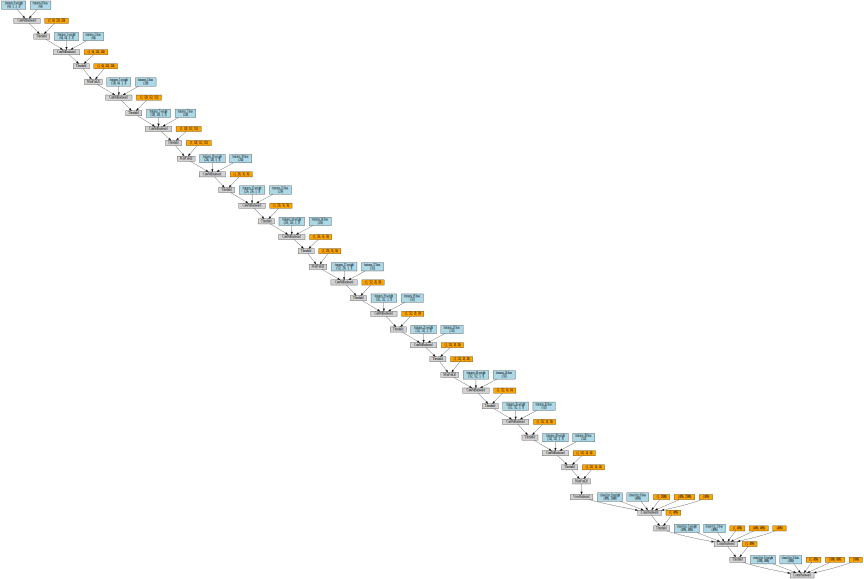

In [12]:
make_dot(y, params)